In [1]:
# import important libraries :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, callbacks

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
# Creating a 'earlystopping' function to trigger termination when desired loss or accuracy is achieved.

class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAccuracy is greater than 96% so terminating training!")
      self.model.stop_training = True

    # elif (logs.get('loss') < 0.3):
    #   print("\nLoss is less than 0.3 so terminating training!")
    #   self.model.stop_training = True

callbacks = myCallback()

## 1. LOADING DATA :

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"files/train",
shuffle=True,
image_size=(256,256),
batch_size=32
)

Found 2100 files belonging to 6 classes.


In [4]:
testing = tf.keras.preprocessing.image_dataset_from_directory(
"files/validation",
shuffle=True,
image_size=(256,256),
batch_size=32
)

Found 528 files belonging to 6 classes.


## 2. DATA EXPLORATION :

In [35]:
disease = dataset.class_names
disease

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [36]:
# .take() method is used to pickup a batch from the complete data, where each batch contains 32 images (as we specified earlier).
for img,lab in dataset.take(1):
    print(img.shape)
    print(lab.numpy())

(32, 256, 256, 3)
[1 2 3 3 5 2 3 1 2 1 2 2 0 4 3 1 1 4 1 5 3 5 4 5 2 2 2 2 1 5 3 4]


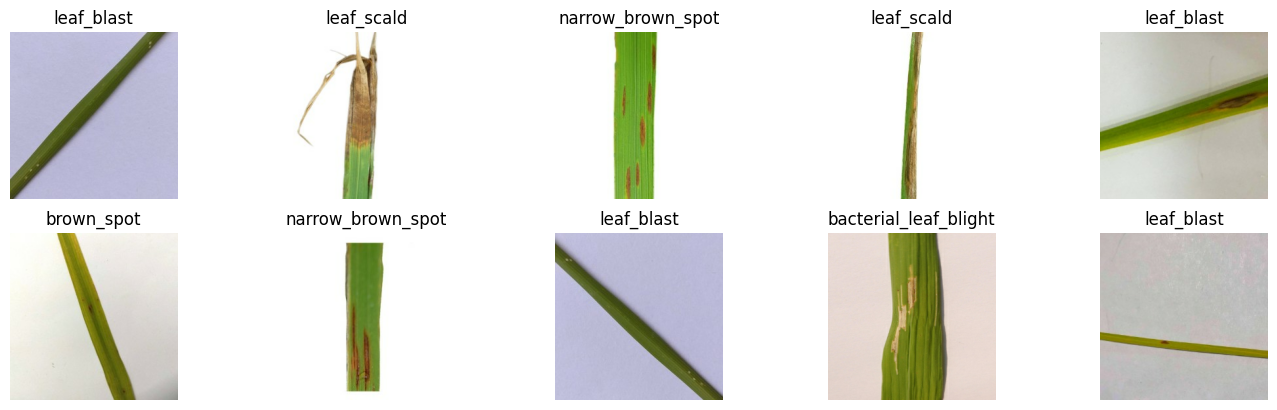

In [40]:
plt.figure(figsize=(17,10))
for img,lab in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1),
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(disease[lab[i]])
        plt.axis('off')

## 3. DATA PREPARATION :

In [8]:
len(testing)//2     # No. of batches in test data.

8

17 batches x 1 batch with 32 image = 544 images.

In [9]:
# traing-test split,
valid = testing.take(8)

As, valid already has 8 batches from top, we can copy remaining into 'test' variable using .skip() method to keep everthing except these 8 batches from top

In [10]:
test = testing.skip(8)

In [11]:
len(valid), len(test), len(dataset)

(8, 9, 66)

8 + 9 = 17 batches & 66 batches of training data, we are good to go now,

In [12]:
# CACHING & PREFETCHING TO MAKE THE PIPELINE HIGH PERFORMANT :

dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## 4. PIPELINES :

- ### RESIZING & RESCALING :

In [13]:
# Rescaling & Resizing data for testing and smoother training.
scale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

- ### DATA AUGMENTATION :

In [14]:
# Adding custom images using data augmentation technique for better accuracy.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

..now that we have scaling and data augmentation layer ready, we can proceed further with our model building part,

- ### MODEL BUILDING :

In [15]:
model =  models.Sequential([
    scale,
    data_augmentation,
    
    # Add CNNs and maxpooling layers (trail & error work)
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.build(input_shape=(32,256,256,3))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
)

In [19]:
his = model.fit(
    dataset,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=valid,
    callbacks=[callbacks]
)

Epoch 1/50
66/66 [==============================] - 138s 2s/step - loss: 1.7338 - accuracy: 0.2186 - val_loss: 1.5420 - val_accuracy: 0.4102
Epoch 2/50
66/66 [==============================] - 129s 2s/step - loss: 1.4879 - accuracy: 0.3814 - val_loss: 1.4563 - val_accuracy: 0.3711
Epoch 3/50
66/66 [==============================] - 129s 2s/step - loss: 1.3997 - accuracy: 0.4190 - val_loss: 1.3317 - val_accuracy: 0.4570
Epoch 4/50
66/66 [==============================] - 128s 2s/step - loss: 1.3055 - accuracy: 0.4671 - val_loss: 1.2276 - val_accuracy: 0.4922
Epoch 5/50
66/66 [==============================] - 129s 2s/step - loss: 1.2597 - accuracy: 0.4757 - val_loss: 1.1558 - val_accuracy: 0.5391
Epoch 6/50
66/66 [==============================] - 130s 2s/step - loss: 1.1093 - accuracy: 0.5614 - val_loss: 0.8441 - val_accuracy: 0.6836
Epoch 7/50
66/66 [==============================] - 129s 2s/step - loss: 0.9472 - accuracy: 0.6205 - val_loss: 0.8335 - val_accuracy: 0.7031
Epoch 8/50
66

Evaluate on test data

In [20]:
score = model.evaluate(test)

9/9 [==============================] - 4s 358ms/step - loss: 0.4027 - accuracy: 0.8603


In [41]:
his.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
loss = his.history["loss"]
val_loss = his.history["val_loss"]
acc = his.history["accuracy"]
val_acc = his.history["val_accuracy"]

In [42]:
len(acc), len(val_acc)

(50, 50)

Text(0.5, 1.0, 'Training & Validation Accuracy')

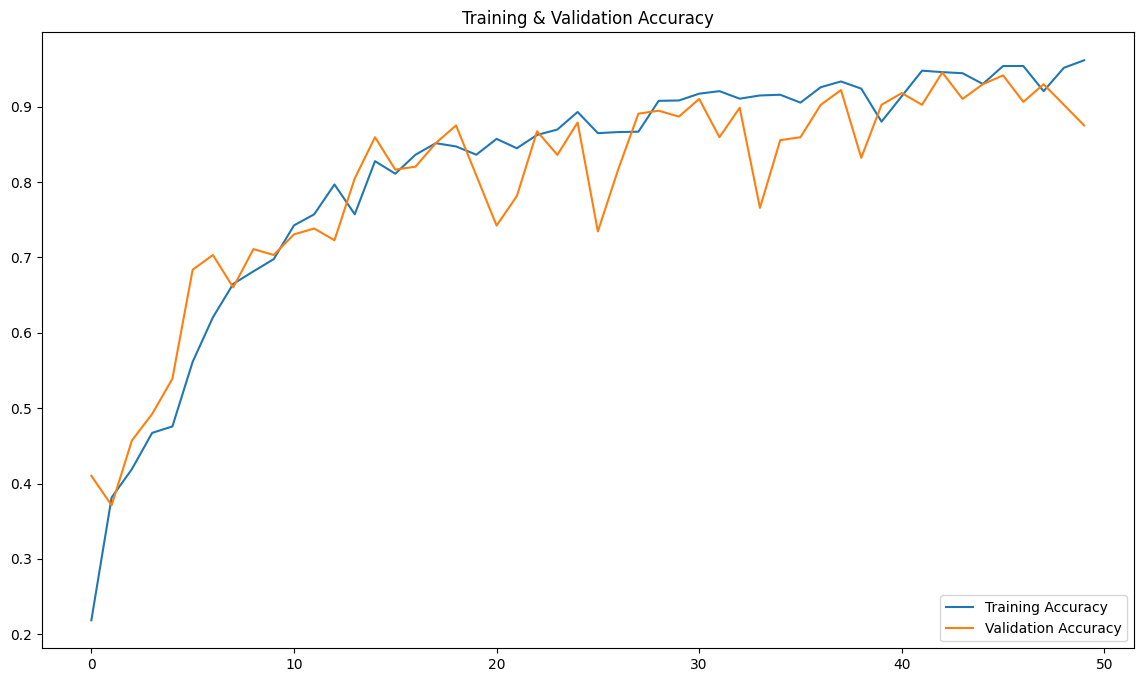

In [43]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')


This graph shows that even increasing the epoch does not make much difference to the accuracy. Let's look at the graph of loss and conclude.

Text(0.5, 1.0, 'Training & Validation Loss')

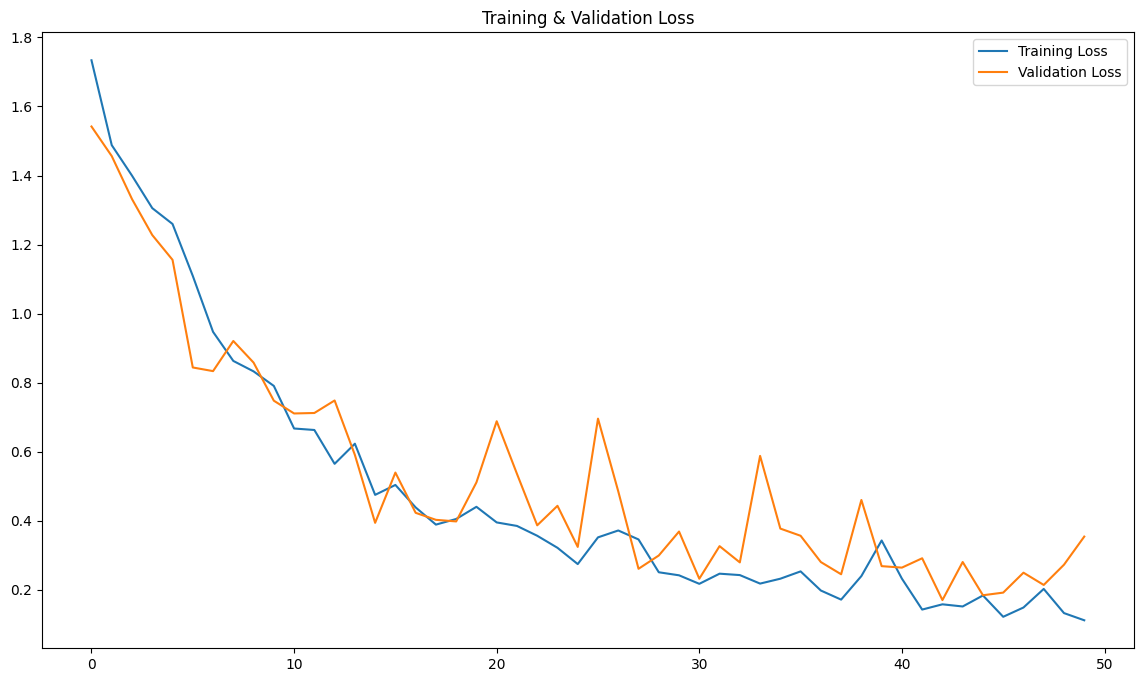

In [48]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training & Validation Loss')

It is possible that the loss would have reduced further, but 0.112 sounds great to me.

- ### TESTING :

In [49]:
batch1 =test.take(1)

1/1 [==============================] - 1s 761ms/step

True : bacterial_leaf_blight
Predicted : bacterial_leaf_blight


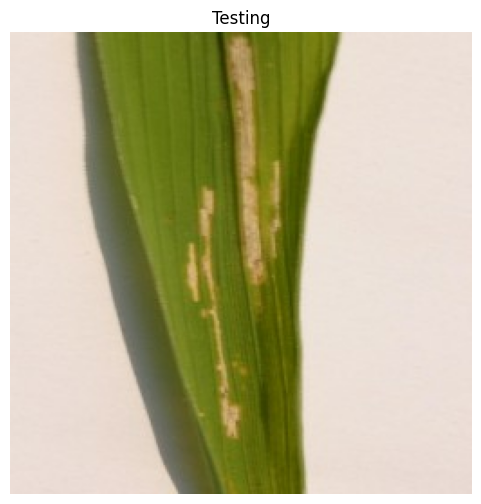

In [55]:
plt.figure(figsize=(6,6))
for img, clf in batch1:
    random_img = img[0].numpy().astype('uint8')
    typ = clf[0].numpy()

    plt.imshow(random_img)
    plt.axis('off')
    plt.title("Testing")
    prediction = model.predict(img)

    print("\nTrue :",disease[typ])
    print("Predicted :",disease[np.argmax(prediction[0])])

In [56]:
def pred(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = tf.expand_dims(array,0)

    prediction = model.predict(array)

    clf = disease[np.argmax(prediction[0])]
    conf = round(100 * (np.max(prediction[0])), 2)
    return clf, conf

1/1 [==============================] - 0s 54ms/step


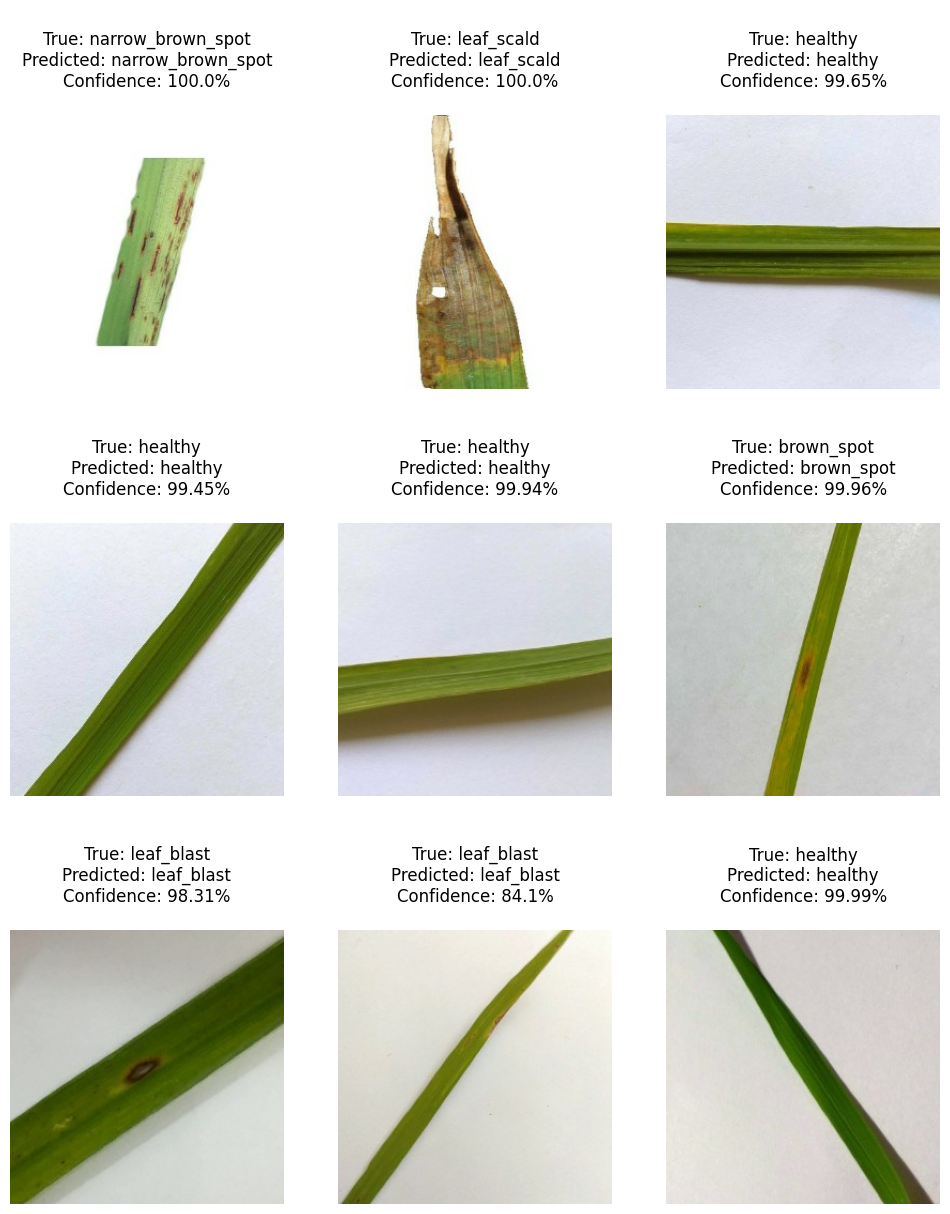

In [59]:
plt.figure(figsize=(12,15))
for img, lab in batch1:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))

        prediction, confidence = pred(img[i].numpy())
        true = disease[lab[i]]
        plt.title(f"\nTrue: {true}\nPredicted: {prediction}\nConfidence: {confidence}%\n")
        plt.axis('off')

In [60]:
import os
model_version= max([float(i) for i in os.listdir("models") ]) + 0.1
print(f"\nCurrent Version : {model_version-0.1}\nRun below cell to create version : {model_version}")


Current Version : 0.1
Run below cell to create version : 0.2


### SAVE MODEL :

In [61]:
# model_version = 0.1
model.save(f"models/{model_version}")
print(f"Version {model_version} Created Successfully.")

Version 0.2 Created Successfully.
